In [1]:
import scanpy as sc

from scprint import scPrint
from scprint.tasks import Embedder, Denoiser, GNInfer

from scdataloader import Preprocessor
from scdataloader.utils import load_genes

import numpy as np
import pandas as pd
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

from collections import Counter
from scprint.model.utils import downsample_profile
from scipy.stats import spearmanr

from scdataloader import DataModule
from scprint.tasks import GNInfer
from anndata.utils import make_index_unique
from bengrn import BenGRN

import json

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint2


In [2]:
m = torch.load('../../xzp23r4p.ckpt', map_location=torch.device('cpu'))

In [8]:
model = scPrint.load_from_checkpoint(
    '../../xzp23r4p.ckpt', precpt_gene_emb=None, classes=m['hyper_parameters']['label_counts'], 
)#strict=False)
    #transformer="normal")
del m

FYI: scPrint is not attached to a `Trainer`.


## Loading the data

In [ ]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


In [5]:
adata = sc.read(
    "data/human_brain_smartv4.h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/f156b755-78c7-4928-917a-be138c153b85.h5ad",
)


  0%|          | 0.00/2.47G [00:00<?, ?B/s]

In [8]:
adata.X.sum()

66897050000.0

In [ ]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())

Dropping layers:  KeysView(Layers with keys: exon, intron)
checking raw counts
removed 0 non primary cells, 49417 renamining
filtered out 0 cells, 49417 renamining
Removed 0 genes.
startin QC
Seeing 10181 outliers (20.60% of total dataset):
done
AnnData object with n_obs × n_vars = 49417 × 70704
    obs: 'suspension_type', 'cluster', 'class', 'subclass', 'sex_ontology_term_id', 'region', 'cortical_layer', 'cell_type_accession', 'cell_type_alias', 'cell_type_alt_alias', 'cell_type_designation', 'donor_id', 'outlier_call', 'outlier_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type_ontology_term_id', 'Specimen ID', 'sample_tissue_type', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cause_of_death', 'PMI (hr)', 'Tissue (RIN)', 'Hemisphere Sampled', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'develo

AnnData object with n_obs × n_vars = 49417 × 35793
    obs: 'suspension_type', 'cluster', 'class', 'subclass', 'sex_ontology_term_id', 'region', 'cortical_layer', 'cell_type_accession', 'cell_type_alias', 'cell_type_alt_alias', 'cell_type_designation', 'donor_id', 'outlier_call', 'outlier_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type_ontology_term_id', 'Specimen ID', 'sample_tissue_type', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cause_of_death', 'PMI (hr)', 'Tissue (RIN)', 'Hemisphere Sampled', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'cortical_layer_colors', 'region_colors', 'schema_reference', 'schema

# training

In [18]:
gene_emb = '../data/main/gene_embeddings.parquet'
datamodule = DataModule(
    collection_name="scPRINT-V2 test", #some, all, preprocessed dataset, all no zhang, 
    gene_embeddings=gene_emb,
    clss_to_weight=[],
    metacell_mode=0,
    clss_to_predict=[],
    hierarchical_clss=[],
    organisms=["NCBITaxon:9606", "NCBITaxon:10090"],
    how="random expr",
    max_len=10_000,
    add_zero_genes=0,
    # how much more you will see the most present vs less present category
    weight_scaler=0,
    batch_size=1,
    num_workers=3,
    prefetch_factor=3,
    n_samples_per_epoch=2000,
    validation_split=0.05,
    do_gene_pos='../data/main/biomart_pos.parquet',
    pin_memory=True,
    test_split=0.05)
testfiles = datamodule.setup()

! no run & transform got linked, call `ln.track()` & re-run
! run input wasn't tracked, call `ln.track()` and re-run
won't do any check but we recommend to have your dataset coming from local storage


/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


100.0% are aligned
seeing a string: loading gene positions as biomart parquet file


KeyError: 'organism_ontology_term_id'

# testing

In [2]:
adata = sc.read(
    "data/lung_smart2.h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ebba0e0-a159-406f-8095-451115673a2c.h5ad",
)

In [11]:
adata = sc.read(
    "data/glio_smart.h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
)

In [4]:
adata = sc.read(
    "data/bone_marrow_5batch.h5ad",
    backup_url='https://datasets.cellxgene.cziscience.com/b2eca8f3-b461-45fd-8639-890bbbf050aa.h5ad'
)

In [3]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True, drop_non_primary=False,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
adata = preprocessor(adata.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 9409 renamining
filtered out 0 cells, 9409 renamining
Removed 39 genes not known to the ontology
Removed 0 duplicate genes
Added 16328 genes in the ontology but not present in the dataset
starting QC
Seeing 5471 outliers (58.14% of total dataset):
done
AnnData object with n_obs × n_vars = 9409 × 70704
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type

In [41]:
adata.layers['true'] = adata.X.copy()

In [42]:
adata.X.sum(1).mean(), adata.shape

390666.25

In [ ]:
1_039_835: 0.85 - 0.56 <- 10_000
390_666: 0.73 - 0.42 <- 4_000


In [43]:
# denoising without
denoise = Denoiser(
    batch_size=10,
    max_len=10_000,
    max_cells=2_000,
    doplot=False,
    num_workers=4,
    predict_depth_mult=5,
    how="most var",
    downsample_expr=0.8,
)
metrics, idx, nadata = denoise(model, adata)
metrics

working on 8922 accepted genes


/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 200/200 [00:46<00:00,  4.28it/s]


AnnData object with n_obs × n_vars = 2000 × 44756
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


{'reco2noisy': 0.2449068152884313,
 'reco2full': 0.7351784139319567,
 'noisy2full': 0.3578098361195504}

In [45]:
nadata = adata[:, adata.var.index.isin(model.genes)]

sc.pp.highly_variable_genes(
    nadata, flavor="seurat_v3", n_top_genes=10_000, span=0.99)

subadata = nadata[:, nadata.var.highly_variable].copy()
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.8)

In [47]:
denoised_adata = sc.external.pp.magic(subadata.copy(), copy=True, n_jobs=10, solver='approximate', verbose=True)

Calculating MAGIC...
  Running MAGIC on 3567 cells and 10000 genes.
  Running MAGIC on 3567 cells and 10000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.67 seconds.
    Calculating affinities...
    Calculated affinities in 0.71 seconds.
  Calculated graph and diffusion operator in 4.39 seconds.
  Calculating imputation...
  Calculated imputation in 0.04 seconds.
Calculated MAGIC in 5.27 seconds.


In [48]:
reco = denoised_adata.X
true = subadata.layers['true'].toarray()
noisy = subadata.X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.17452298137061376,
 'reco2full': 0.4422112299809244,
 'noisy2full': 0.35767520456666974}

In [ ]:
# embedding and cell type prediction

In [7]:
embed = Embedder(how="random expr", max_len=4000, num_workers=12, pred_embedding = ["cell_type_ontology_term_id"], batch_size=60)

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 1111/1111 [07:12<00:00,  2.57it/s]


AnnData object with n_obs × n_vars = 66609 × 44756
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:171: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="sprint_leiden")


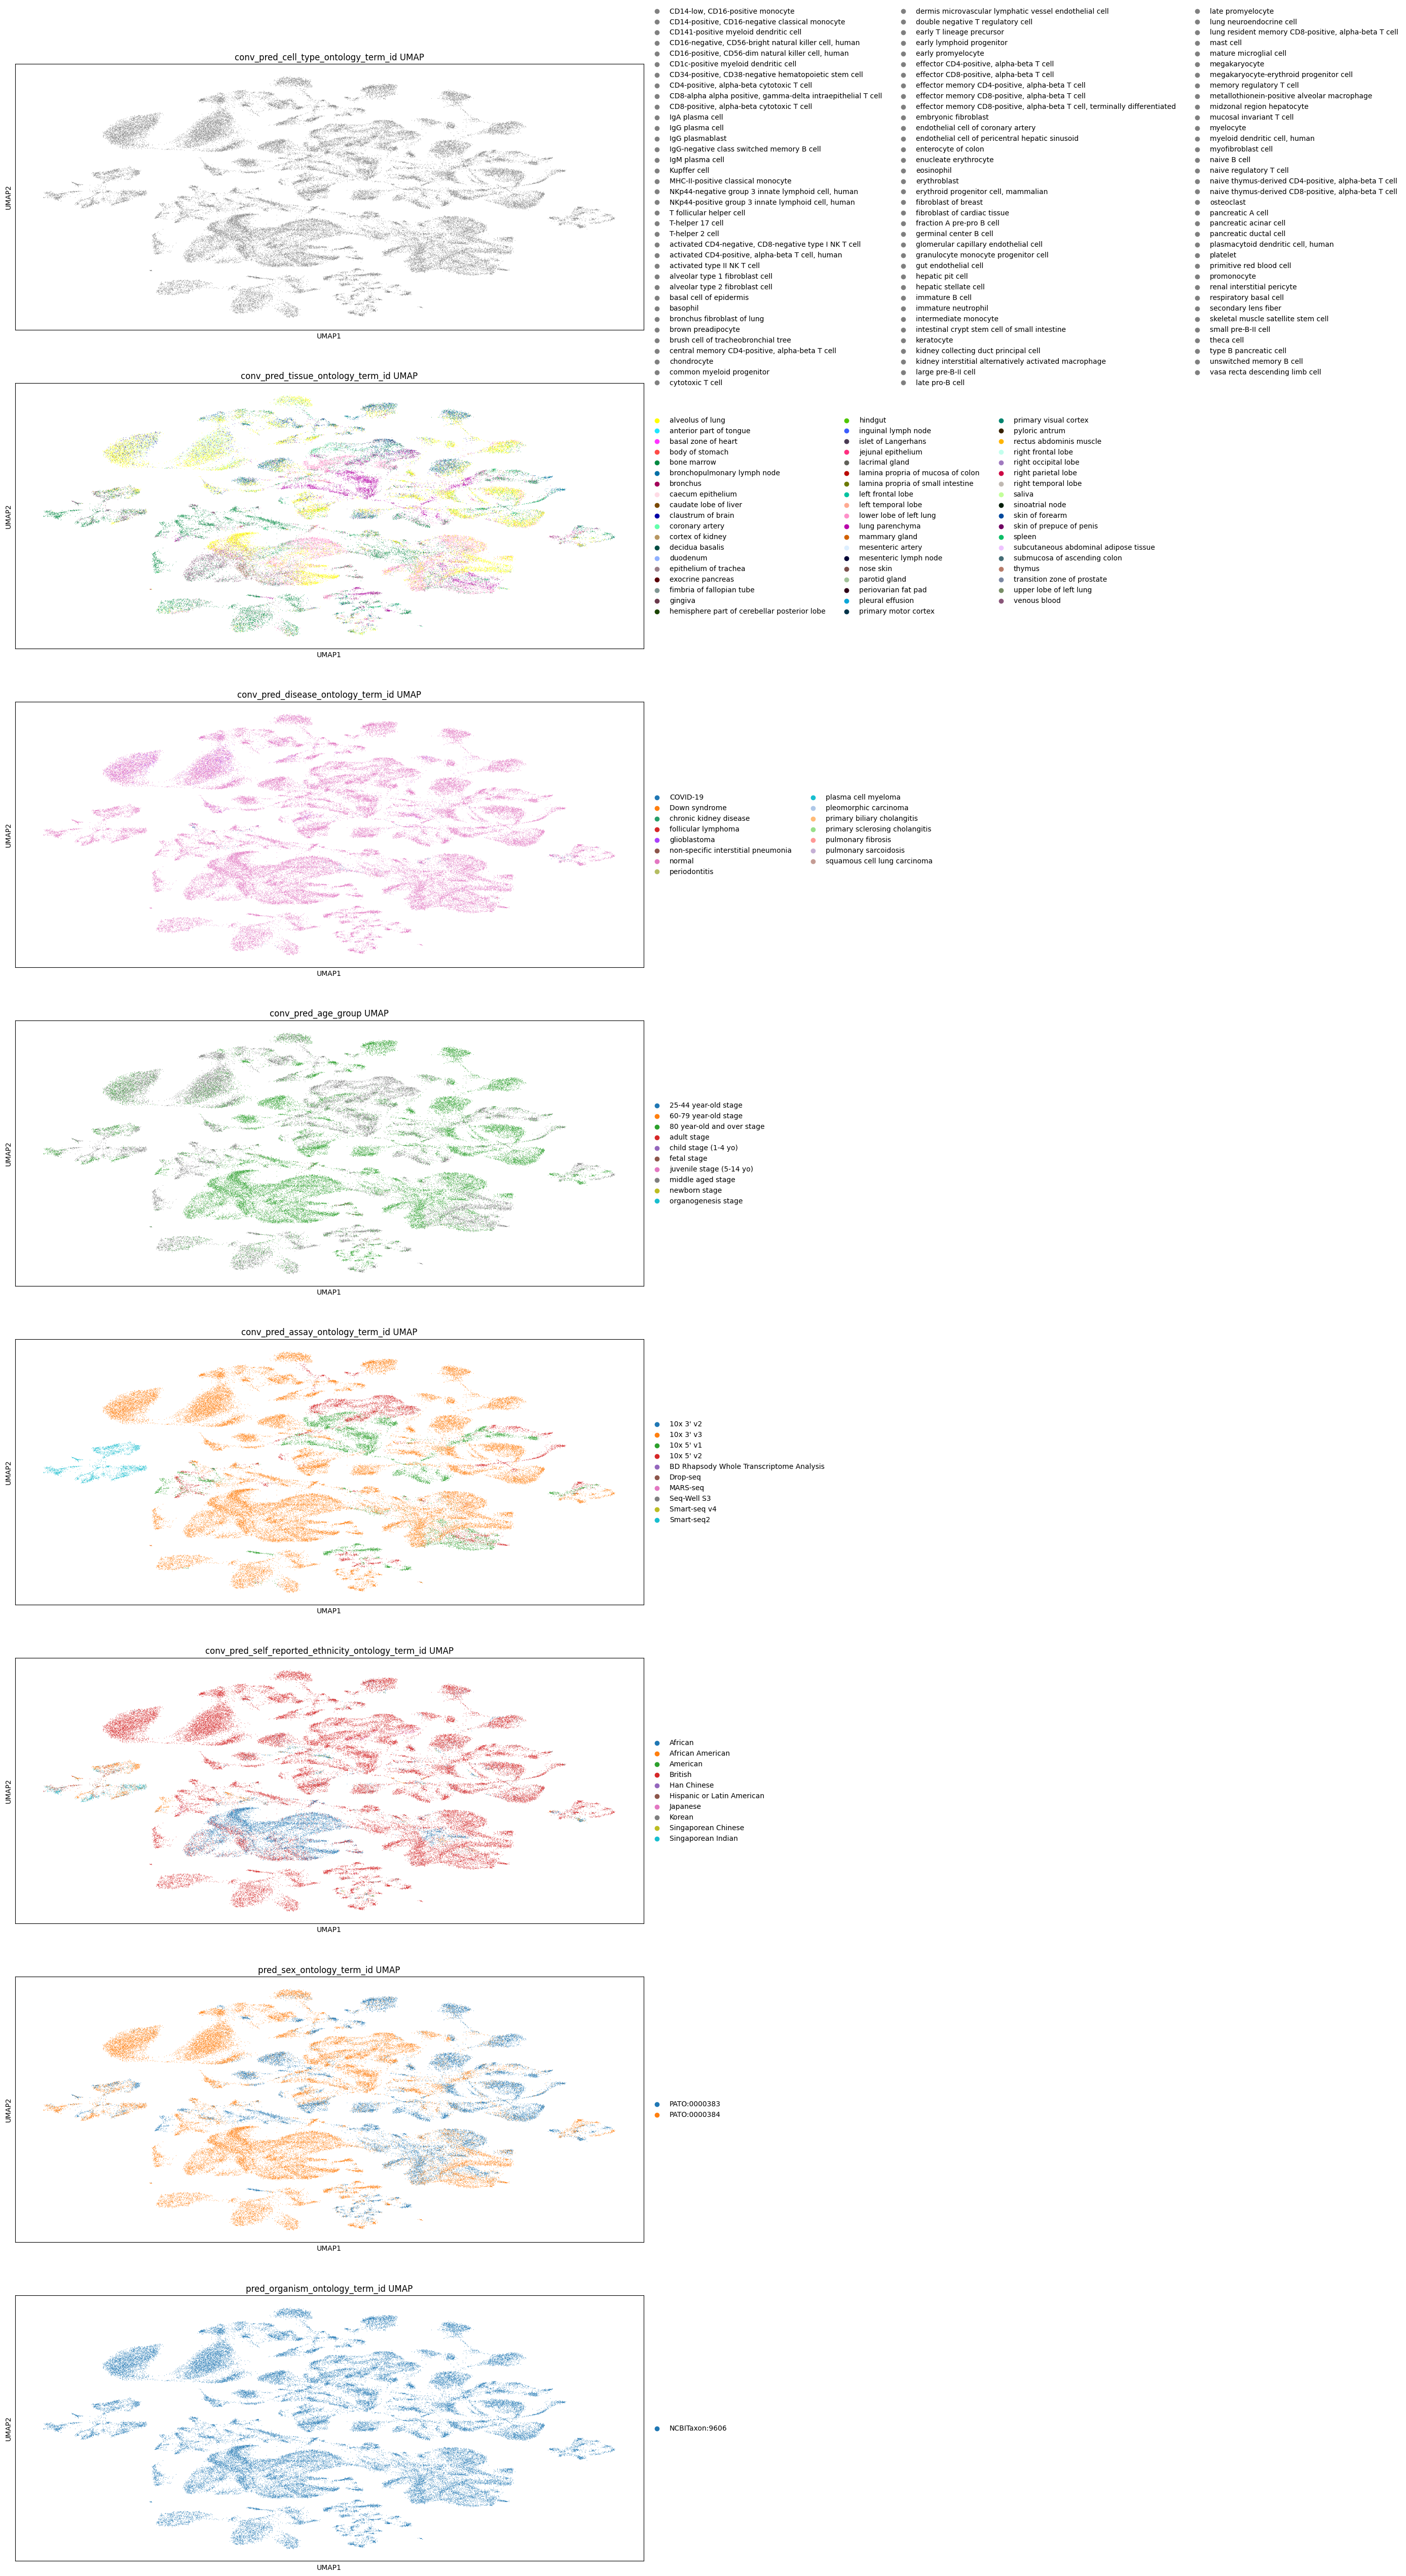

couldn't log to tensorboard
couldn't log to wandb
too few cells to compute a clustering
     cell_type_ontology_term_id
     accuracy: 0.5177378432343978
 
     tissue_ontology_term_id
     accuracy: 0.1559549009893558
 
     disease_ontology_term_id
     accuracy: 0.9789818192736717
 
     assay_ontology_term_id
     accuracy: 0.9803780269933492
 
     self_reported_ethnicity_ontology_term_id
     accuracy: 0.743030303030303
 
     sex_ontology_term_id
     accuracy: 0.8648681109159423
 
     organism_ontology_term_id
     accuracy: 1.0
 


In [8]:
n_adata, metrics = embed(model, adata.copy(), cache=False)

In [84]:
n_adata

AnnData object with n_obs × n_vars = 11201 × 70704
    obs: 'Dataset', 'donor_id', 'suspension_type', 'Original_annotation', 'CellHint_harmonised_group', 'Curated_annotation', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tissue_type', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id

... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


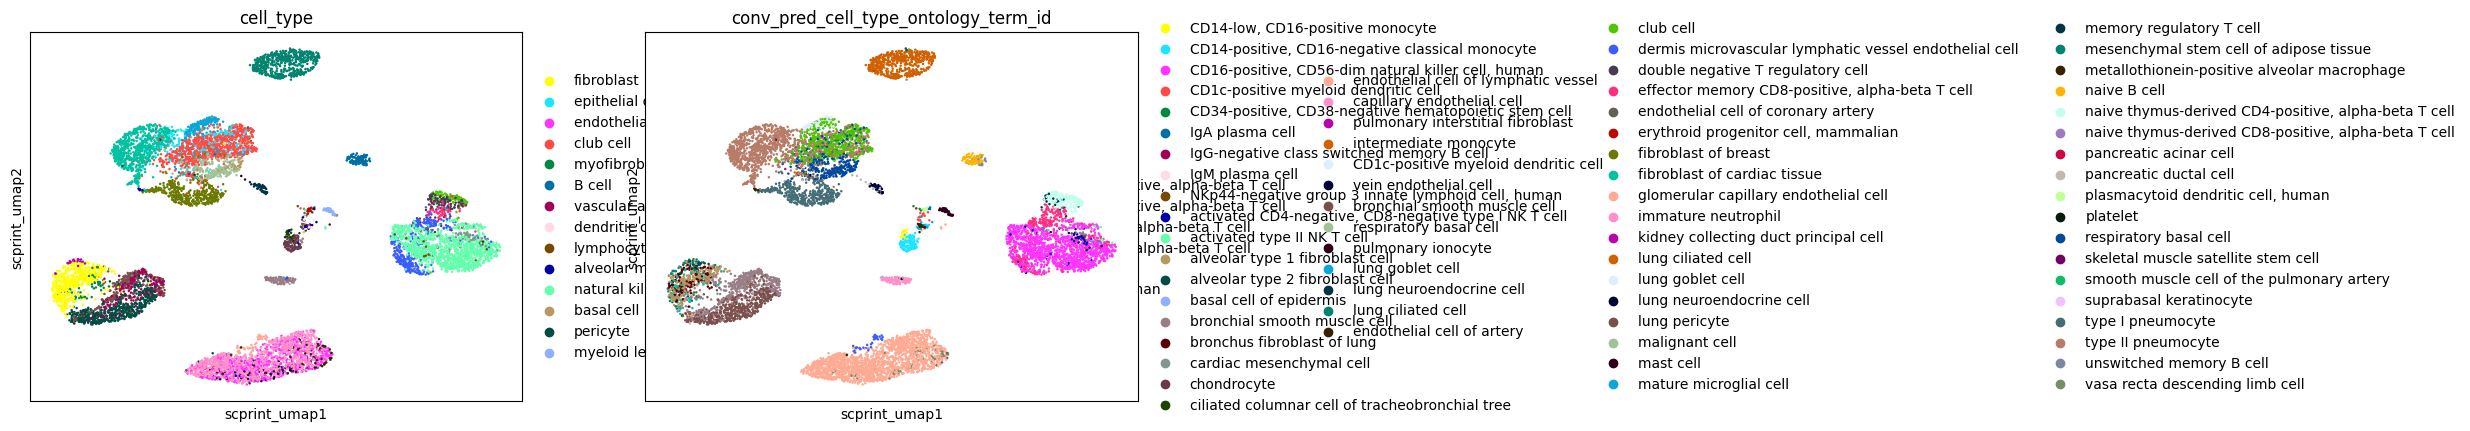

In [68]:
sc.pl.embedding(n_adata, basis="scprint_umap",color=["cell_type", "conv_pred_cell_type_ontology_term_id"])

In [76]:
adata.obs['assay_ontology_term_id']

index
A1_B002014.gencode.vH29     EFO:0008931
A1_B003138.gencode.vH29     EFO:0008931
A1_B003140.gencode.vH29     EFO:0008931
A10_B003138.gencode.vH29    EFO:0008931
A12_B003141.gencode.vH29    EFO:0008931
                               ...     
M5_B001771.gencode.vH29     EFO:0008931
N2_B001769.gencode.vH29     EFO:0008931
N2_B002460.gencode.vH29     EFO:0008931
O2_B001774.gencode.vH29     EFO:0008931
O7_B001774.gencode.vH29     EFO:0008931
Name: assay_ontology_term_id, Length: 9409, dtype: category
Categories (1, object): ['EFO:0008931']

In [9]:
bm = Benchmarker(
    n_adata,
    batch_key="assay_ontology_term_id", #batch, tech
    label_key="cell_type_ontology_term_id", #celltype
    embedding_obsm_keys=["scprint_emb"],
    bio_conservation_metrics=BioConservation(isolated_labels=False),
    batch_correction_metrics=BatchCorrection(),
    n_jobs=20,
)
bm.benchmark()

/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]INFO:2025-04-15 14:11:35,178:jax._src.xla_bridge:925: Unable to initialize backend 'cuda': 
[d3graph] INFO> Unable to initialize backend 'cuda': 
INFO:2025-04-15 14:11:35,181:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[d3graph] INFO> Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-15 14:11:35,232:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared o

INFO     CL:0001058 consists of a single batch or is too small. Skip.                                              


Metrics:  60%|██████    | 6/10 [25:21<09:56, 149.21s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 1/1 [25:24<00:00, 1524.55s/it]


In [10]:
bm.get_results(min_max_scale=False)

KMeans NMI        KMeans ARI  Silhouette label  \
Embedding                                                           
scprint_emb          0.583405          0.294107          0.517006   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

                        cLISI  Silhouette batch             iLISI  \
Embedding                                                           
scprint_emb          0.996011          0.806162               0.0   
Metric Type  Bio conservation  Batch correction  Batch correction   

                         KBET Graph connectivity    PCR comparison  \
Embedding                                                            
scprint_emb          0.327459           0.636251                 0   
Metric Type  Batch correction   Batch correction  Batch correction   

            Batch correction Bio conservation            Total  
Embedding                                                       
scprint_emb         0.353974         0.597632         0.500169  
Metric Type  Aggregate score  Aggregate score  Aggregate score

# gene networks

In [4]:
adata.obs.cell_type.value_counts()

cell_type
natural killer cell                                     1232
club cell                                                898
capillary endothelial cell                               872
endothelial cell                                         816
pulmonary alveolar type 2 cell                           760
lung ciliated cell                                       551
fibroblast                                               533
pericyte                                                 518
pulmonary alveolar type 1 cell                           421
naive thymus-derived CD8-positive, alpha-beta T cell     378
bronchial smooth muscle cell                             346
respiratory basal cell                                   240
lung goblet cell                                         233
epithelial cell                                          201
vascular associated smooth muscle cell                   176
naive thymus-derived CD4-positive, alpha-beta T cell     131
B cell        

... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a futur

avg link count: 25090081, sparsity: 1.0
base enrichment
Top central genes: []


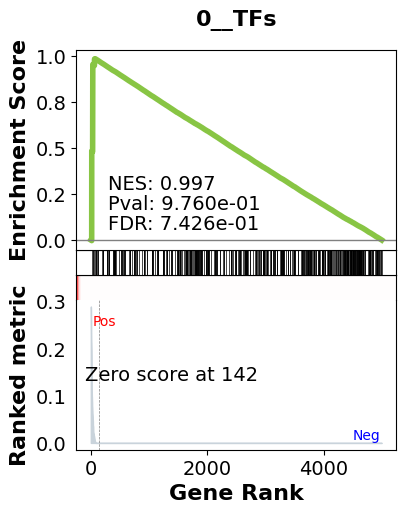

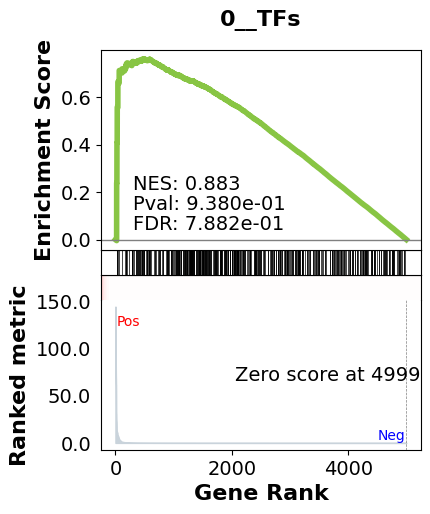

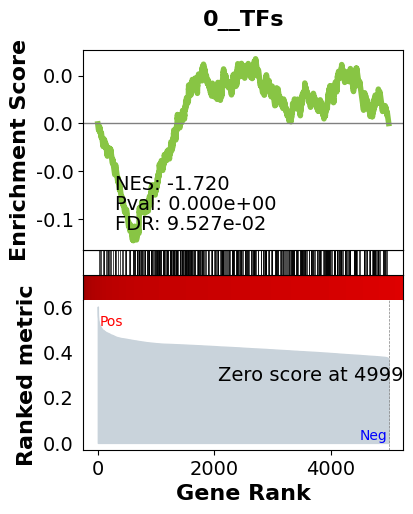

_________________________________________
TF specific enrichment
found some significant results for  25.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3402 genes
intersection pct: 0.6804
precision:  0.001281277638322514 
recall:  1.0 
random precision: 0.00128165437388215


 98%|█████████▊| 126/128 [00:02<00:00, 53.93it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:906: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 53.96it/s]


Average Precision (AP):  0.001678607221875735
Area Under Precision-Recall Curve (AUPRC):  0.0016768719165809074
EPR: 1.0524599133939867


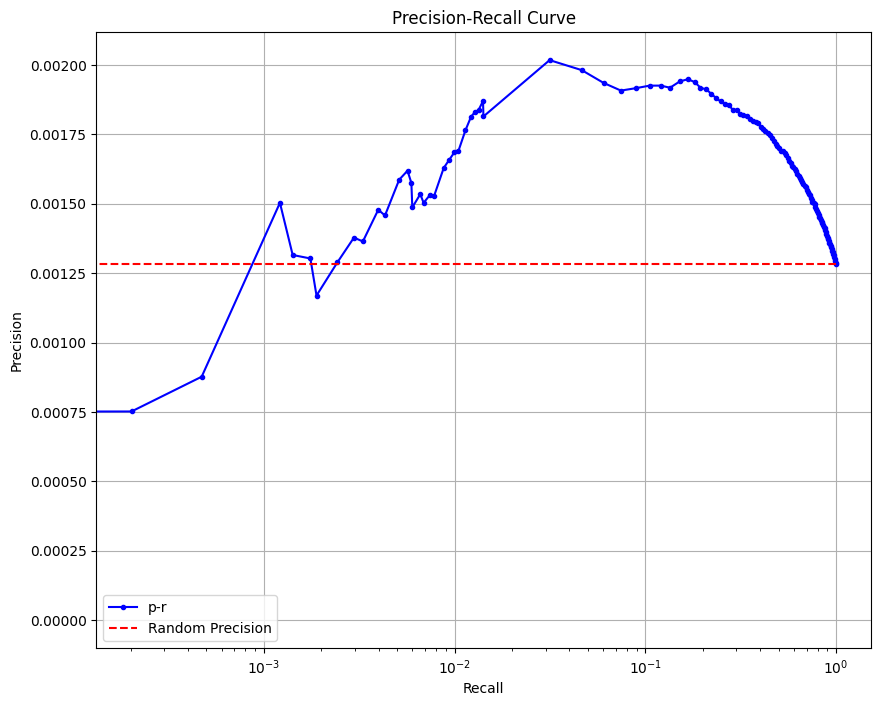

{'endothelial cell_scprint_full': {'TF_enr': True,
  'enriched_terms_Targets': ['celltype.gmt__Immune system cells',
   'celltype.gmt__Enterocytes',
   'celltype.gmt__Myeloid Dendritic cells',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Microglial cells',
   'celltype.gmt__Endothelial cells',
   'celltype.gmt__Airway goblet cells',
   'celltype.gmt__Kupffer cells',
   'celltype.gmt__Epsilon cells',
   'celltype.gmt__Endothelial cell',
   'celltype.gmt__Gamma (PP) cells',
   'celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__HSC/MPP cells',
   'celltype.gmt__Plasmacytoid Dendritic cells',
   'celltype.gmt__Ductal cells',
   'celltype.gmt__Pericytes',
   'celltype.gmt__Smooth muscle cells',
   'celltype.gmt__Myoepithelial cells',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Proximal tubule cells',
   'celltype.gmt__Astrocytes',
   'celltype.gmt__Renal Vesicle cells',
   'celltype.gmt__Pulmonary alveolar type II cells',
   'celltype.gmt__Cholangiocytes'],
  'sig

In [9]:
# gene network inference without
metrics = {}
clf_omni = None
shapes = []
for celltype in ['endothelial cell']: #['oligodendrocyte precursor cell']:
    grn_inferer = GNInfer(
                        how="most var across",
                        preprocess="softmax",
                        head_agg='mean',
                        filtration="none",
                        forward_mode="none",
                        num_genes=5_000,
                        max_cells=1000,
                        doplot=False,
                        batch_size=10,
                        cell_type_col="cell_type",
                        layer=list(range(model.nlayers))[:]
                        )
    grn = grn_inferer(model, adata, cell_type=celltype)
    grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
    metrics[celltype+'_scprint_full'] = BenGRN(grn).scprint_benchmark()
    #grn.write_h5ad(f'../data/temp/grn_{celltype}_scprint_f.h5ad')
metrics

In [49]:
FOLDER = '/home/ml4ig1/task_grn_inference/resources_test/grn_benchmark/'
adata = sc.read_h5ad(FOLDER+'evaluation_data/adamson_sc.h5ad')
reg = json.load(open(FOLDER+'prior/regulators_consensus_adamson.json'))

In [50]:
n_features_theta_min = np.asarray(
    [reg[gene_name]["0"] for gene_name in adata.var_names], dtype=int
)
n_features_theta_median = np.asarray(
    [reg[gene_name]["0.5"] for gene_name in adata.var_names], dtype=int
)
n_features_theta_max = np.asarray(
    [reg[gene_name]["1"] for gene_name in adata.var_names], dtype=int
)


In [51]:
adata

AnnData object with n_obs × n_vars = 1472 × 4932
    obs: 'perturbation', 'is_control', 'perturbation_type', 'n_genes'
    var: 'n_cells'
    uns: 'data_reference', 'data_url', 'dataset_description', 'dataset_id', 'dataset_name', 'dataset_organism', 'dataset_summary', 'normalization_id'
    layers: 'X_norm'

In [52]:
adata.var["n_features_theta_"+str(0.0)] = n_features_theta_min
adata.var["n_features_theta_"+str(0.5)] = n_features_theta_median
adata.var["n_features_theta_"+str(1.0)] = n_features_theta_max


In [53]:
adata.write_h5ad('../../benGRN/data/adamson_sc.h5ad')

In [10]:
adata = sc.read_h5ad('../../benGRN/data/adamson_sc.h5ad')

In [57]:
grn.grn

symbol         TSPAN6         STPG1        NIPAL3         LAS1L        ANKIB1  \
symbol                                                                          
TSPAN6   4.643926e-08  1.659722e-06  1.198268e-07  1.559675e-06  3.824897e-06   
STPG1    4.782305e-09  4.662970e-06  1.206461e-07  2.296092e-06  1.903460e-05   
NIPAL3   5.104444e-09  4.914413e-09  6.667045e-09  7.853157e-08  1.045481e-07   
LAS1L    4.142110e-07  7.040341e-05  1.363588e-07  3.415729e-06  7.887294e-06   
ANKIB1   1.350821e-08  1.724094e-06  2.351976e-08  1.091582e-07  8.595348e-07   
...               ...           ...           ...           ...           ...   
PCDH20   1.535364e-06  1.055687e-04  2.774282e-06  6.482620e-06  4.375247e-06   
TMEM272  1.449026e-07  2.933191e-05  5.631787e-07  1.078619e-06  1.182005e-05   
C2orf81  1.664245e-06  7.802654e-05  1.858616e-06  9.141510e-06  7.308146e-06   
PRRC2B   4.545619e-06  2.215473e-04  2.133118e-06  7.907308e-06  1.664337e-05   
F8A1     1.360398e-06  2.290507e-04  3.768085e-06  8.316441e-06  3.713304e-06   

symbol        CYP51A1         HECW1        KLHL13       CYP26B1          ICA1  \
symbol                                                                          
TSPAN6   1.516583e-05  1.563489e-07  8.517782e-08  9.899654e-09  2.288655e-07   
STPG1    1.636758e-07  1.193126e-06  4.945625e-07  5.865201e-09  3.463873e-07   
NIPAL3   6.312828e-07  1.748683e-08  9.403863e-09  3.741159e-10  2.151361e-08   
LAS1L    5.431752e-07  1.746226e-05  6.440911e-06  5.133793e-07  1.884224e-07   
ANKIB1   5.960566e-07  7.542626e-08  1.211545e-07  1.039108e-08  5.868628e-08   
...               ...           ...           ...           ...           ...   
PCDH20   9.540036e-06  7.721273e-07  1.014811e-06  9.695452e-07  1.832474e-06   
TMEM272  5.062264e-06  1.610679e-06  2.853974e-06  1.009118e-06  7.934290e-07   
C2orf81  7.703453e-06  9.953331e-06  1.477036e-06  7.303525e-06  1.870016e-06   
PRRC2B   8.448743e-06  9.862448e-07  2.856927e-06  3.996336e-07  2.228912e-06   
F8A1     6.540140e-06  5.269595e-06  2.837681e-07  2.932584e-06  6.932247e-07   

symbol         DBNDD1          RBM5         MTMR7         SARM1       POLDIP2  \
symbol                                                                          
TSPAN6   4.567497e-08  7.045175e-06  1.387173e-07  2.360387e-08  4.661994e-07   
STPG1    4.761639e-06  4.011943e-06  4.864516e-06  4.262050e-06  2.903646e-07   
NIPAL3   1.624739e-07  2.031206e-06  1.339542e-08  1.428464e-08  3.964902e-08   
LAS1L    4.414873e-06  8.092748e-06  1.192677e-05  4.525898e-06  2.322353e-07   
ANKIB1   3.428975e-08  6.070684e-07  3.421020e-08  1.557350e-08  1.455819e-07   
...               ...           ...           ...           ...           ...   
PCDH20   1.556368e-05  1.330275e-06  1.543517e-04  9.832698e-05  1.647532e-05   
TMEM272  3.541634e-06  1.369005e-06  3.910156e-05  1.843331e-05  2.990004e-07   
C2orf81  4.095114e-06  2.427733e-06  1.153847e-04  6.254578e-05  4.365822e-06   
PRRC2B   8.751805e-06  1.720585e-05  8.991178e-07  8.330004e-06  5.243821e-06   
F8A1     4.694707e-06  5.213778e-06  5.643992e-07  2.136389e-05  2.310348e-05   

symbol          KDM1A          RBM6      ARHGAP33           ST7          DVL2  \
symbol                                                                          
TSPAN6   5.654057e-06  4.126646e-06  8.761053e-08  4.703277e-07  3.787372e-07   
STPG1    2.658931e-05  6.433748e-06  3.028271e-08  2.157740e-06  1.317990e-07   
NIPAL3   1.572385e-07  2.992354e-07  1.239169e-08  1.748801e-08  2.026036e-08   
LAS1L    1.354027e-05  6.229070e-06  2.488232e-06  1.293100e-06  6.275757e-06   
ANKIB1   5.856666e-07  3.965464e-07  2.934366e-08  2.034695e-07  1.978083e-07   
...               ...           ...           ...           ...           ...   
PCDH20   8.720001e-06  4.438622e-06  5.665968e-06  3.656328e-06  1.462737e-05   
TMEM272  1.883430e-05  3.029919e-06  5.761656e-07  3.980349e-06  3.695308e-07   
C2orf81  1.238813e-05  3.177

In [11]:
from bengrn.GeneRNIB_reg2 import run_gene_rnib


In [18]:
adata.var.index

Index(['AP006222.2', 'RP11-54O7.1', 'RP11-54O7.3', 'SAMD11', 'HES4', 'ISG15',
       'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4',
       ...
       'ITGB2', 'ITGB2-AS1', 'LINC00205', 'BX322559.3', 'COL18A1',
       'AL133493.2', 'COL6A1', 'AP001469.7', 'C21orf58', 'PCNT'],
      dtype='object', name='gene_name', length=4932)

In [21]:
grn.var.index

Index(['DPM1', 'FIRRM', 'STPG1', 'NIPAL3', 'ENPP4', 'SEMA3F', 'ANKIB1', 'LAP3',
       'CD99', 'SNX11',
       ...
       'nan-23', 'SMIM38', 'TMDD1', 'nan-24', 'nan-25', 'nan-26', 'nan-27',
       'nan-28', 'nan-29', 'HOMEZ'],
      dtype='object', name='symbol', length=5000)

In [32]:
grn.shape, adata.shape

((816, 1055), (1472, 1055))

In [38]:
run_gene_rnib(
    adata,
    grn
)


[d3graph] INFO> Reading input files


> /home/ml4ig1/Documents code/benGRN/bengrn/GeneRNIB_reg2.py(370)run_gene_rnib()
    368 
    369     pdb.set_trace()
--> 370     for theta in [0.0, 0.5, 1.0]:
    371         logger.info(f"Static approach (theta={theta}):")
    372         n_features = prturb_adata.var["n_features_theta_" + str(theta)]



[d3graph] INFO> Static approach (theta=0.0):
100%|██████████| 1055/1055 [00:10<00:00, 102.00it/s]
[d3graph] INFO> Static approach (theta=0.5):
100%|██████████| 1055/1055 [00:12<00:00, 85.83it/s]
[d3graph] INFO> Static approach (theta=1.0):
100%|██████████| 1055/1055 [00:16<00:00, 64.12it/s]


r2-theta-0.0  r2-theta-0.5  r2-theta-1.0
0        0.0086      0.025824      0.046002

In [ ]:
# gene network inference

In [ ]:
# embedding and cell type prediction with

In [ ]:
# embedding and cell type prediction without